## Trip types - Hard clustering
In the following, an attempt is made to divide the cab journeys into clusters using the prepared data set, with which different types of drivers are to be identified.

The approach of hard clustering with KMeans is used.

### Imports and preparatory calculations
In the following, the necessary libraries are imported and the data set is loaded and displayed superficially. 

Furthermore, preparatory calculations are performed to encode categorical variables.

In [92]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [93]:
# Import dataset
trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')

In [94]:
# General presentation of the dataframe
trips_df.info()
trips_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170568 entries, 0 to 170567
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   taxi_id                 170568 non-null  int64         
 1   trip_start_timestamp    170568 non-null  datetime64[ns]
 2   trip_end_timestamp      170568 non-null  datetime64[ns]
 3   trip_seconds            170568 non-null  float64       
 4   trip_miles              170568 non-null  float64       
 5   pickup_census_tract     170568 non-null  int64         
 6   dropoff_census_tract    170568 non-null  int64         
 7   pickup_community_area   170568 non-null  int64         
 8   dropoff_community_area  170568 non-null  int64         
 9   fare                    170568 non-null  float64       
 10  tips                    170568 non-null  float64       
 11  tolls                   170568 non-null  float64       
 12  Extras                  170568

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,h3_07_dropoff,h3_08_pickup,h3_08_dropoff,h3_09_pickup,h3_09_dropoff,pickup_centroid,dropoff_centroid,datetime,temp,precip
0,1,2015-01-01 00:00:00,2015-01-01 00:00:00,540.0,0.17,17031080300,17031063301,8,6,7.25,...,872664c10ffffff,882664c13bfffff,882664c101fffff,892664c13afffff,892664c101bffff,POINT (-87.63576009 41.90749193),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
1,2,2015-01-01 00:00:00,2015-01-01 00:00:00,480.0,0.90,17031320100,17031081500,32,8,6.25,...,872664c1effffff,882664c1e3fffff,882664c1e1fffff,892664c1e2fffff,892664c1e0fffff,POINT (-87.620992913 41.884987192),POINT (-87.626214906 41.892507781),2015-01-01,-7.0115,0
2,3,2015-01-01 00:15:00,2015-01-01 00:30:00,780.0,5.50,17031281900,17031063301,28,6,14.05,...,872664c10ffffff,882664c1adfffff,882664c101fffff,892664c1acfffff,892664c101bffff,POINT (-87.642648998 41.879255084),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
3,4,2015-01-01 00:30:00,2015-01-01 00:45:00,780.0,2.30,17031062900,17031031400,6,3,8.85,...,872664d89ffffff,882664c163fffff,882664d893fffff,892664c162fffff,892664d8923ffff,POINT (-87.656411531 41.936237179),POINT (-87.645378762 41.962178629),2015-01-01,-7.0115,0
4,5,2015-01-01 00:00:00,2015-01-01 00:15:00,600.0,2.40,17031071500,17031070700,7,7,8.85,...,872664c12ffffff,882664c115fffff,882664c121fffff,892664c114fffff,892664c1257ffff,POINT (-87.631717366 41.914616286),POINT (-87.673807238 41.929272532),2015-01-01,-7.0115,0


In [95]:
# Initialize the LabelEncoder and add it to the dataframe
label_encoder = LabelEncoder()
trips_df['payment_type_encoded'] = label_encoder.fit_transform(trips_df['payment_type'])
trips_df['weekday_encoded'] = label_encoder.fit_transform(trips_df['is_weekday'])

### Calculation of the optimal number of clusters with the elbow method
First, we compute the inertia for up to 10 clusters and then use the visualization to select the optimal number of clusters at the point where an elbow can be seen.

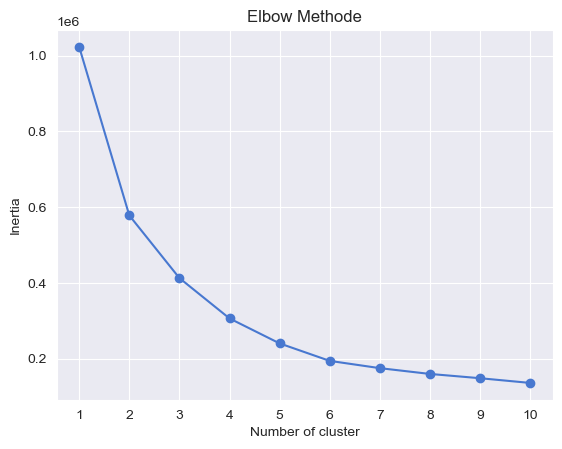

In [96]:
# Features used in clustering 
numerical_columns = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'payment_type_encoded', 'weekday_encoded']

# Standardizing the numerical columns in the dataframe
scaler = StandardScaler()
trips_df[numerical_columns] = scaler.fit_transform(trips_df[numerical_columns])

# Maximum number of clusters to consider for KMeans
k_max = 10

clusters = []
losses = []

# Loop to fit KMeans models for different number of clusters and store the results
for k in range(1, k_max + 1):
    model = KMeans(n_clusters=k, n_init=10, random_state=4711)
    model.fit(trips_df[numerical_columns])
    clusters.append(k)
    losses.append(model.inertia_)

# Visualization
plt.plot(clusters, losses, marker='o')
plt.title('Elbow Methode')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.xticks(clusters)
plt.show()

It can be seen that the inertia does not decrease noticeably after 4 to 5 clusters. Therefore, 4 clusters are now calculated in K Means in order to further anlayze them.

### Clustering with KMeans and first representation of the clusters
First, we compute the inertia for up to 10 clusters and then use the visualization to select the optimal number of clusters at the point where an elbow can be seen.

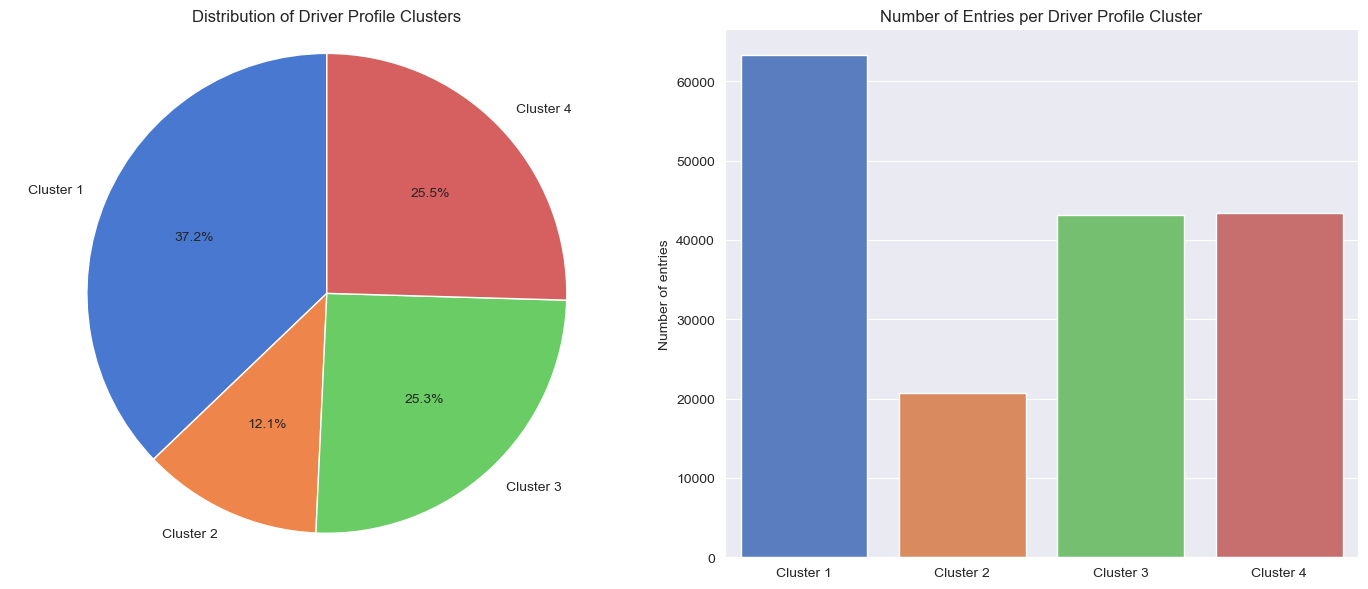

In [97]:
# Standardization and KMeans Clustering
scaler = StandardScaler()
trips_df[numerical_columns] = scaler.fit_transform(trips_df[numerical_columns])

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
trips_df['driver_profile_cluster'] = kmeans.fit_predict(trips_df[numerical_columns])

cluster_counts = trips_df['driver_profile_cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(trips_df)) * 100

# Fetching the muted palette colors for the clusters
colors_muted = sns.color_palette("muted", num_clusters)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Adjust cluster labels from 0-based (0,1,2,3) to 1-based (1,2,3,4)
adjusted_labels = ["Cluster " + str(i+1) for i in cluster_counts.index]

# Pie chart
axes[0].pie(cluster_percentages, labels=adjusted_labels, autopct='%1.1f%%', startangle=90, colors=colors_muted)
axes[0].set_title('Distribution of Driver Profile Clusters')
axes[0].axis('equal')

# Countplot
sns.countplot(data=trips_df, x='driver_profile_cluster', ax=axes[1], palette=colors_muted, order=cluster_counts.index)
axes[1].set_title('Number of Entries per Driver Profile Cluster')

# Adjust the x-ticks labels for the countplot
axes[1].set_xticklabels(adjusted_labels)
axes[1].set_xlabel("")
axes[1].set_ylabel("Number of entries")

plt.tight_layout()
plt.show()

### Analysis of clusters for sensitivity to different features
In the following, the clusters already created are plotted against different features from the data set and analyzed for their sensitivity in order to enable a classification of the customers or drivers in the trips of the clusters.

#### Driver Profile Cluster vs Day of the Week

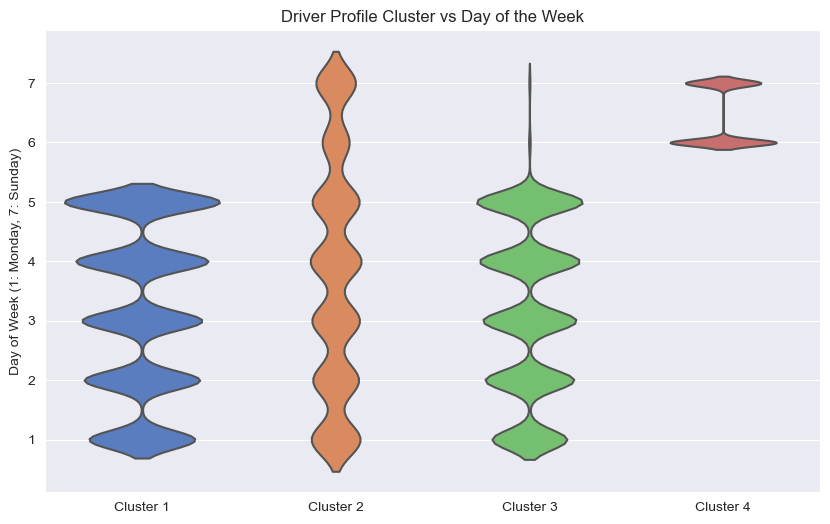

In [98]:
# Create a new DataFrame with the necessary columns for the violin plot
# Adjust 'dayofweek_start' by adding 1 so that the days shift from 1-7
violin_df = trips_df.copy()
violin_df['dayofweek_start'] += 1

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=violin_df, x='driver_profile_cluster', y='dayofweek_start', inner=None, scale='count', palette='muted')

# Modify x-axis labels
cluster_labels = [f"Cluster {i+1}" for i in range(num_clusters)]
plt.xticks(range(num_clusters), cluster_labels)
plt.xlabel('')  # Remove x-axis label
plt.ylabel('Day of Week (1: Monday, 7: Sunday)')
plt.title('Driver Profile Cluster vs Day of the Week')
plt.show()

It is noticeable that cluster 1 is only used on weekdays and cluster 4 only on weekends. Furthermore, clusters 2 and 3 are represented on all days, whereby cluster 2 remains clearly more even and cluster 3 only has a low level of expression on the weekend.

Thus, it can currently be assumed that cluster 1 is business travelers and cluster 2 is domestic travelers who regularly take cabs. Cluster 3 cannot be precisely classified, while cluster 4 is probably weekend visitors.

#### Driver Profile Cluster vs Temperatur

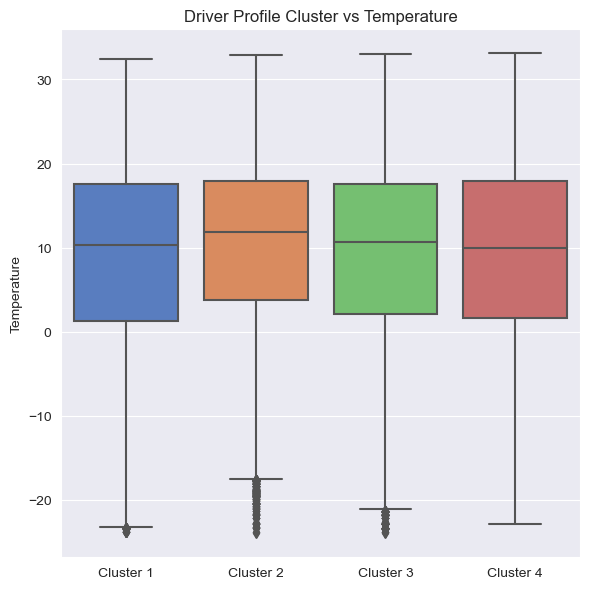

In [99]:
# Create a new DataFrame with the necessary columns for the boxplots
boxplot_df = trips_df[['driver_profile_cluster', 'temp']]

# Create the boxplot
plt.figure(figsize=(6, 6))
order = sorted(boxplot_df['driver_profile_cluster'].unique())
sns.boxplot(data=boxplot_df, x='driver_profile_cluster', y='temp', palette='muted', order=order)
cluster_labels = [f"Cluster {i+1}" for i in order]
plt.xticks(range(len(cluster_labels)), cluster_labels)
plt.xlabel('')
plt.ylabel('Temperature')
plt.title('Driver Profile Cluster vs Temperature')
plt.tight_layout()
plt.show()

If now the temperature is considered it is noticeable that actually all clusters are not temperature sensitive whereby however cluster 2 and 3 fall out, where more outliers are at temperatures with approx. -20 degrees. This complements the assumption

#### Driver Profile Cluster vs. distance and vs. duration of the trip

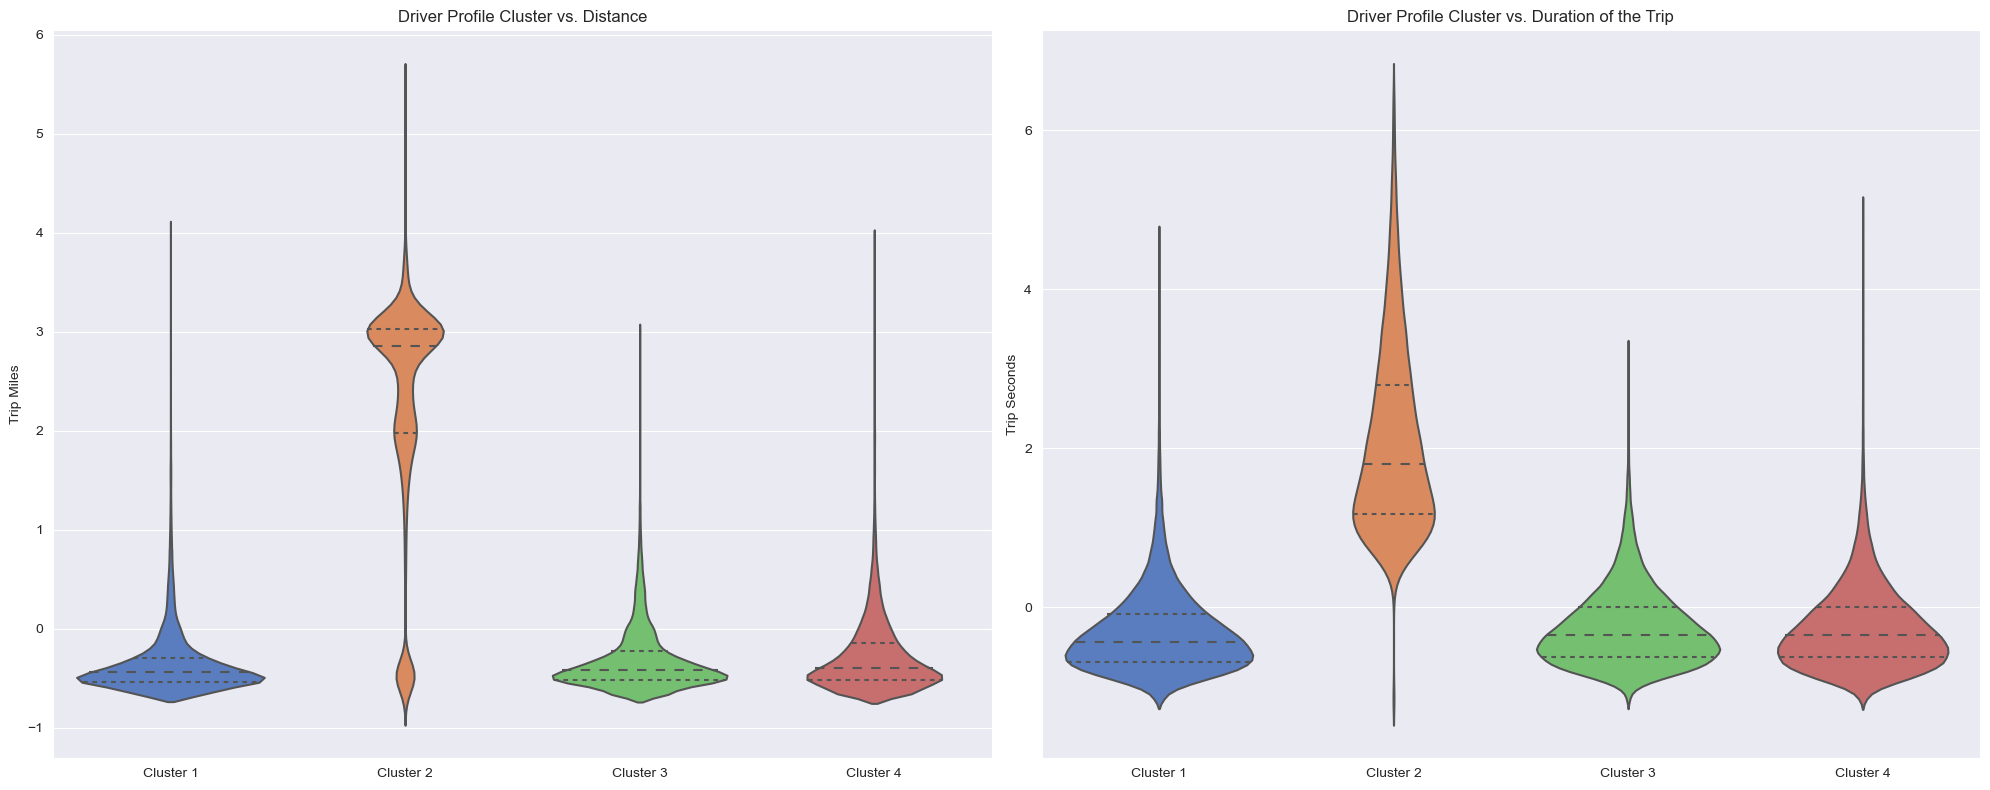

In [100]:
# Set the color palette to "muted"
sns.set_palette("muted")

# Create Figure and Axes objects for the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Get the unique clusters
unique_clusters = sorted(trips_df['driver_profile_cluster'].unique())

# Generate the correct cluster labels
cluster_labels = [f"Cluster {i+1}" for i in unique_clusters]

# Violin-Plot for trip_miles
sns.violinplot(x='driver_profile_cluster', y='trip_miles', data=trips_df, inner="quartile", ax=axes[0])
axes[0].set_title('Driver Profile Cluster vs. Distance')
axes[0].set_ylabel('Trip Miles')
axes[0].set_xlabel('')
axes[0].set_xticklabels(cluster_labels)

# Violin-Plot for trip_seconds
sns.violinplot(x='driver_profile_cluster', y='trip_seconds', data=trips_df, inner="quartile", ax=axes[1])
axes[1].set_title('Driver Profile Cluster vs. Duration of the Trip')
axes[1].set_ylabel('Trip Seconds')
axes[1].set_xlabel('')
axes[1].set_xticklabels(cluster_labels)

plt.tight_layout()
plt.show()


#### Driver Profile Cluster vs. Start Time of the trip

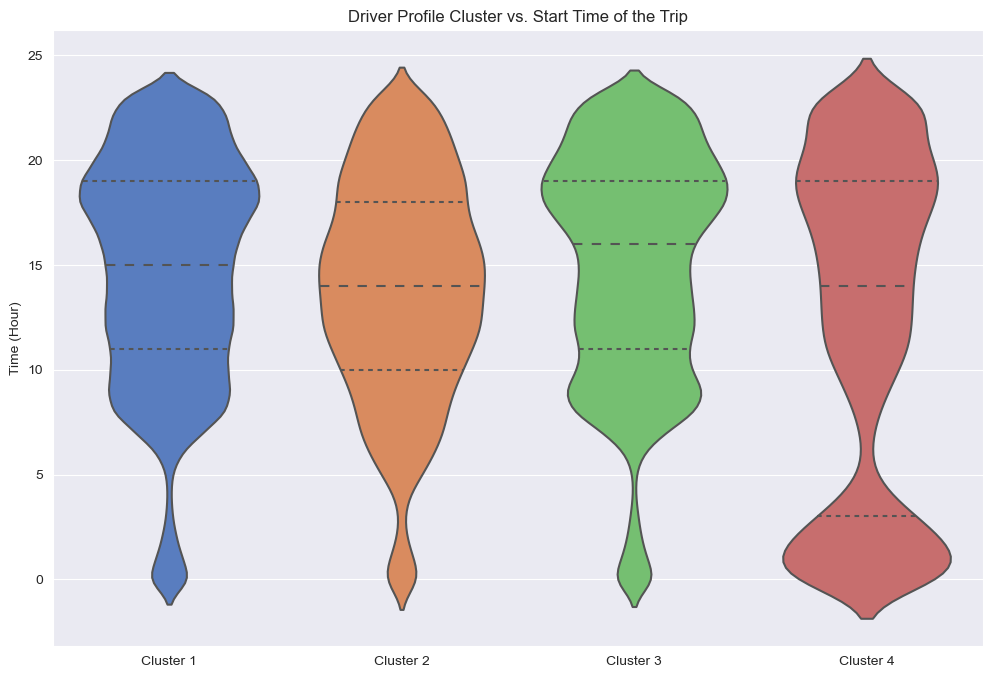

In [101]:
# Extract only the hour from trip_start_timestamp
trips_df_copy = trips_df.copy()
trips_df_copy['hour'] = trips_df_copy['trip_start_timestamp'].dt.hour

# Create the Violin-Plot
plt.figure(figsize=(12, 8))
sns.violinplot(x="driver_profile_cluster", y="hour", data=trips_df_copy, palette="muted", inner="quartile")

# Setting the title and y-label, and removing x-label 
plt.title('Driver Profile Cluster vs. Start Time of the Trip')
plt.ylabel('Time (Hour)')
plt.xlabel('')

# Adjust the x-tick labels to have the cluster names as Cluster 1, Cluster 2, etc.
unique_clusters = sorted(trips_df_copy['driver_profile_cluster'].unique())
cluster_labels = [f"Cluster {i+1}" for i in unique_clusters]
plt.xticks(ticks=range(len(unique_clusters)), labels=cluster_labels)
plt.show()

#### Driver Profile Cluster vs. Tips

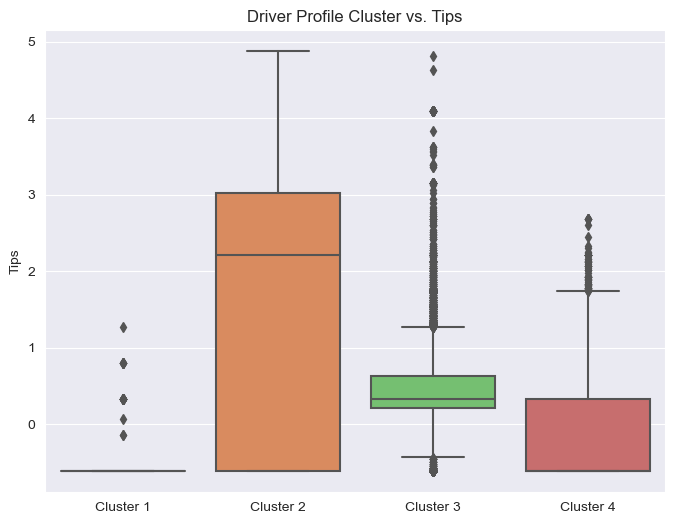

In [102]:
# Create a new DataFrame with necessary columns for the boxplot
boxplot_df = trips_df[['driver_profile_cluster', 'tips']]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=boxplot_df, x='driver_profile_cluster', y='tips', palette='muted')

# Setting the title and y-label, and removing x-label 
plt.title('Driver Profile Cluster vs. Tips')
plt.ylabel('Tips')
plt.xlabel('')

# Adjust the x-tick labels to have the cluster names as Cluster 1, Cluster 2, etc.
unique_clusters = sorted(boxplot_df['driver_profile_cluster'].unique())
cluster_labels = [f"Cluster {i+1}" for i in unique_clusters]
plt.xticks(ticks=range(len(unique_clusters)), labels=cluster_labels)

plt.show()

#### Distribution of payment types among the Driver Profile Cluster 
Note: Payment types with less than one percent share in the cluster have been hidden for better visualization.

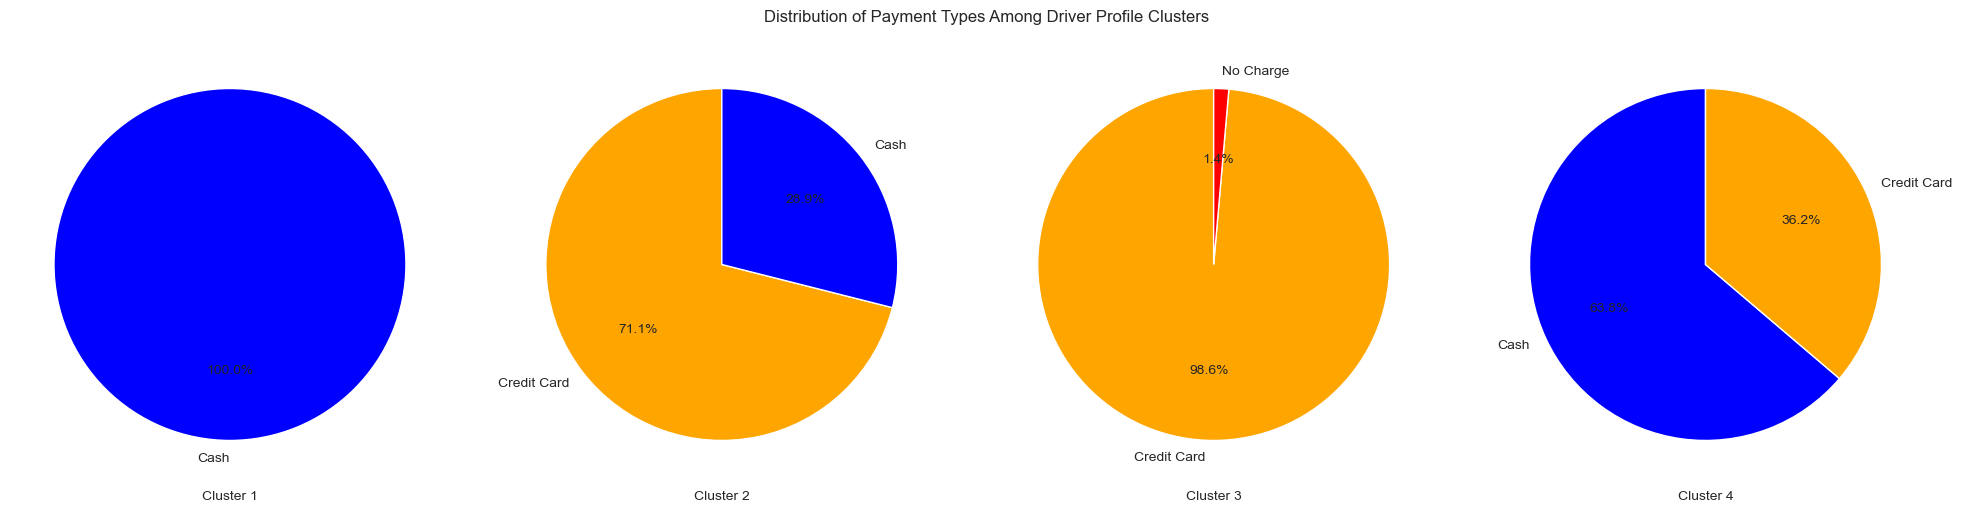

In [103]:
unique_clusters = trips_df['driver_profile_cluster'].unique()

# Color assignments for specific payment methods
color_dict = {
    'Credit Card': 'orange',
    'No Charge': 'red',
    'Cash': 'blue'
}

# Create a plot with 1 row and as many columns as unique_clusters
fig, axes = plt.subplots(nrows=1, ncols=len(unique_clusters), figsize=(20, 5))

for index, cluster in enumerate(sorted(unique_clusters)):
    subset = trips_df[trips_df['driver_profile_cluster'] == cluster]
    counts = subset['payment_type'].value_counts(normalize=True) * 100  # in percentage

    # Exclude clusters with less than 1%
    counts = counts[counts >= 1]
    labels = counts.index

    # Retrieve/create colors for the current labels
    colors = [color_dict.get(label, 'grey') for label in labels]  # 'grey' is the default color

    # Draw the pie chart on the current axis object
    axes[index].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Adjusting the cluster number and setting it as x-axis title to display below each pie chart
    axes[index].set_xlabel(f'Cluster {cluster + 1}')
    axes[index].xaxis.set_label_position('bottom')  # ensure label is at the bottom

# Set main title for the entire graphic
plt.suptitle('Distribution of Payment Types Among Driver Profile Clusters')
plt.tight_layout()
plt.show()